In [0]:
%%capture
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torch torchvision livelossplot

**Main imports**

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import random
from time import sleep
from livelossplot import PlotLosses

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [0]:
class_names = np.array(['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
            
# define the transformations to be applied to the dataset
transforms = torchvision.transforms.Compose([
		torchvision.transforms.ToTensor(),
		])

train_dataset = torchvision.datasets.CIFAR10('data', train = True, download = True, transform = transforms)
test_dataset = torchvision.datasets.CIFAR10('data', train = False, download = True, transform = transforms)

# filter the dataset to contain just the horse/bird classes
idx = torch.tensor(train_dataset.targets) == 2
idx += torch.tensor(train_dataset.targets) == 7
train_dataset = torch.utils.data.dataset.Subset(train_dataset, np.where(idx==1)[0])

idx = torch.tensor(test_dataset.targets) == 2
idx += torch.tensor(test_dataset.targets) == 7
test_dataset = torch.utils.data.dataset.Subset(test_dataset, np.where(idx==1)[0])

# load training data
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=64, drop_last=True)

# load test data
test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=True, batch_size=64, drop_last=True)

# separate the dataset into horse and bird classes, for later generations
horses = []
birds = []
for loader in [train_loader, test_loader]:
	  for i, data in enumerate(loader, 0):
		    inputs, labels = data[0], data[1]
		    for j in range(len(data[0])):
			      if labels[j] == 7:
				        horses += [inputs[j]]
			      if labels[j] == 2:
				        birds += [inputs[j]]

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 10000
> Size of test dataset 2000


**View some of the test dataset**

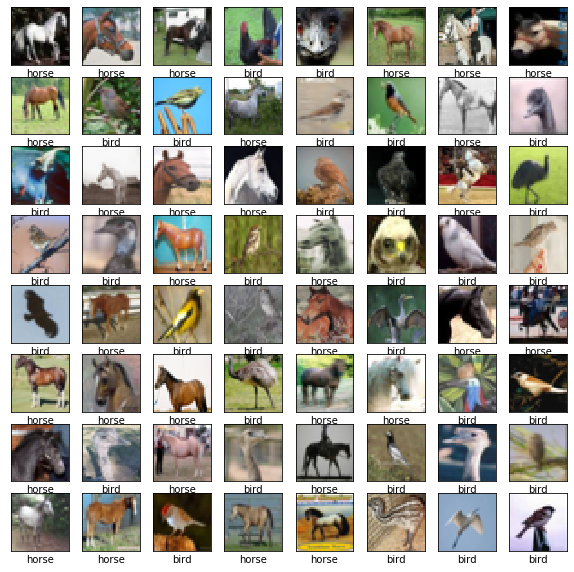

In [0]:
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

**Define three models: (1) VAE Encoder, (2) VAE Decoder, and (3) Critic**

In [0]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=128, f = 16):
        super(Encoder, self).__init__()
        self.f = f

        self.encode_conv = nn.Sequential(
            nn.Conv2d(3, f, 4, 2, 1),
            nn.BatchNorm2d(f),
            nn.LeakyReLU(0.2),
            nn.Conv2d(f, f*2, 4, 2, 1),
            nn.BatchNorm2d(f*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(f*2, f*4, 3, 1, 1),
            nn.BatchNorm2d(f*4),
            nn.LeakyReLU(0.2),
        )

        # latent space
        self.fc11 = nn.Linear(f*4*8*8, hidden_size)
        self.fc12 = nn.Linear(f*4*8*8, hidden_size)

    def encode(self, x):
        out = self.encode_conv(x)
        out = out.view(out.size(0), -1)
        return self.fc11(out), self.fc12(out)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


class Decoder(nn.Module):
    def __init__(self, hidden_size=128, f = 16):
        super(Decoder, self).__init__()
        self.f = f

        self.decode_conv = nn.Sequential(
            nn.ConvTranspose2d(f*4, f*2, 4, 2, 1),
            nn.BatchNorm2d(f*2),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(f*2, f, 4, 2, 1),
            nn.BatchNorm2d(f),
            nn.LeakyReLU(0.2),
            nn.Conv2d(f, 3, 3, 1, 1),
            nn.Sigmoid()
        )

        self.fc2 = nn.Linear(hidden_size, f*4*8*8)

    def decode(self, z):
        out = F.relu(self.fc2(z))
        out = out.view(out.size(0), self.f*4, 8, 8)
        out = self.decode_conv(out)
        return out

    def forward(self, z):
        return self.decode(z)


# create critic network - almost identical to encoder
class Critic(nn.Module):
    def __init__(self, f = 32, depth = 2, latent = 1):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(3, f, 4, 2, 1),
            nn.BatchNorm2d(f),
            nn.LeakyReLU(0.2),
            nn.Conv2d(f, f*2, 4, 2, 1),
            nn.BatchNorm2d(f*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(f*2, latent, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        score = self.critic(x)
        # reduce the tensor to 2d, and convert into a list of means
        score = score.view(score.size(0), -1)
        score = torch.mean(score, -1)
        return score

# initialise networks - 0.001 learning rate is typical for autoencoders, but too high for GAN components such as a discriminator/critic
E = Encoder().to(device)
optimiser_E = torch.optim.Adam(E.parameters(), lr=0.0001)

D = Decoder().to(device)
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.0001)

C = Critic().to(device)
optimiser_C = torch.optim.Adam(C.parameters(), lr=0.0001)

# set number of epochs
epochs = 1000
liveplot = PlotLosses()

**Loss Function to calculate VAE Loss**

In [0]:
def vae_loss(p, x, mu, logvar):
    BCE = F.binary_cross_entropy(p.view(-1, 32 * 32 * 3), x.view(-1, 32 * 32 * 3), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE + KLD)

**Main training loop**

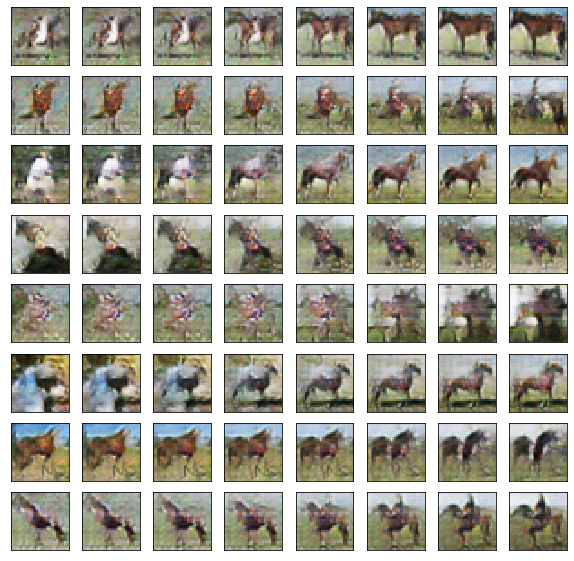

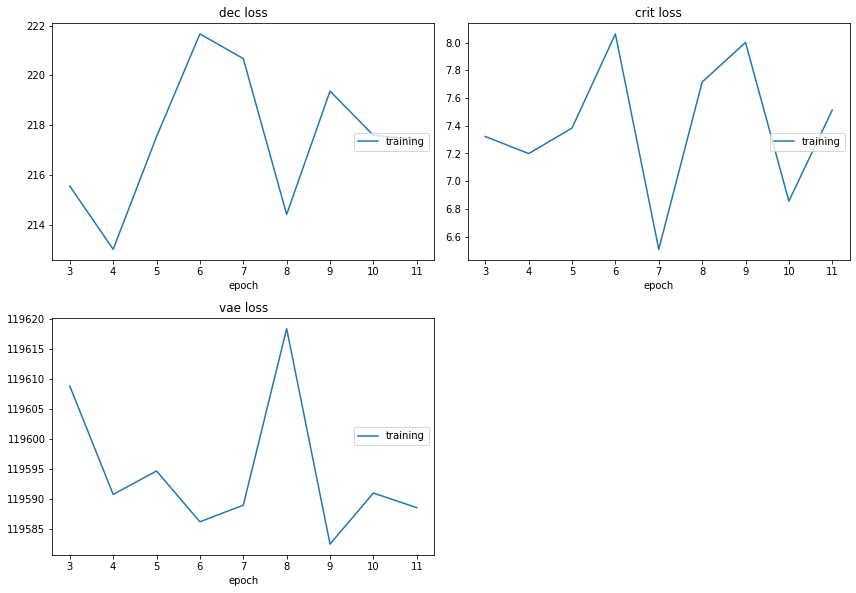

dec loss:
training   (min:  213.019, max:  223.354, cur:  217.435)

crit loss:
training   (min:    6.508, max:    8.064, cur:    7.514)

vae loss:
training   (min: 119577.772, max: 119618.324, cur: 119588.542)


KeyboardInterrupt: ignored

In [0]:
# if running on a local host, this can be used to load previously trained networks
"""path_e = "./adv-vae-e.pth"
path_d = "./adv-vae-d.pth"
path_c = "./adv-vae-c.pth"

try:
    E.load_state_dict(torch.load(path_e))
    D.load_state_dict(torch.load(path_d))
    C.load_state_dict(torch.load(path_c))
except:
    print("could not load")"""

# training loop
while (epoch<epochs):
    
    # arrays for metrics
    logs = {}
    dec_loss_arr = np.zeros(0)
    vae_loss_arr = np.zeros(0)
    crit_loss_arr = np.zeros(0)

    for loader in [train_loader, test_loader]:
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # get all necessary outputs from the networks
            z, mu, logvar = E(inputs)
            outputs = D(z)
            crit_r = C(inputs)
            crit_f = C(outputs)
            
            # calculate loss values related to the critic, using binary cross-entropy (better for classification usecases than mean squared error)
            l_crit_f = F.binary_cross_entropy(crit_f, torch.zeros_like(crit_f).to(device), reduction='sum')
            l_crit_r = F.binary_cross_entropy(crit_r, torch.ones_like(crit_r).to(device), reduction='sum')
            l_crit = (l_crit_f + l_crit_r) / 2
            l_ae_crit = F.binary_cross_entropy(crit_f, torch.ones_like(crit_f).to(device), reduction='sum')

            # get the vae loss
            l_vae = vae_loss(outputs, inputs, mu, logvar)

            # train vae on the vae loss
            optimiser_E.zero_grad()
            optimiser_D.zero_grad()
            l_vae.backward(retain_graph = True)
            optimiser_E.step()
            # train just the decoder part on the critic loss, so that the decoder is trained to generate an image that can fool the critic
            l_ae_crit.backward(retain_graph = True)
            optimiser_D.step()

            # train the critic to make more accurate predictions
            optimiser_C.zero_grad()
            l_crit.backward()
            optimiser_C.step()

            # update loss arrays for plotting
            vae_loss_arr = np.append(vae_loss_arr, l_vae.item())
            crit_loss_arr = np.append(crit_loss_arr, l_crit.item())
            dec_loss_arr = np.append(dec_loss_arr, l_ae_crit.item())

    # plot some examples, with their interpolations
    plt.figure(figsize=(10,10))
    for n in range(8):
        a, b = random.randrange(0, len(horses)), random.randrange(0, len(birds))
        z_1 = horses[a].to(device)
        z_2 = birds[b].to(device)

        z_1_code, _, _ = E(z_1.unsqueeze(0))
        z_2_code, _, _ = E(z_2.unsqueeze(0))

        for m in range(8):
            plt.subplot(8,8,(8*n)+m+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            pegasus = D((m / 7) * z_1_code + (1 - (m / 7)) * z_2_code).squeeze(0)
            pegasus = pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0)

            plt.imshow(pegasus, cmap=plt.cm.binary)

    liveplot.update({
        'dec loss': dec_loss_arr.mean(),
        'crit loss': crit_loss_arr.mean(),
        'vae loss': vae_loss_arr.mean()
    })
    liveplot.draw()
    sleep(1.)

    epoch = epoch+1

    # if running on a local host, this can be used to save the trained networks
    """torch.save(E.state_dict(), path_e)
    torch.save(D.state_dict(), path_d)
    torch.save(C.state_dict(), path_c)"""


**Generate some Outputs**

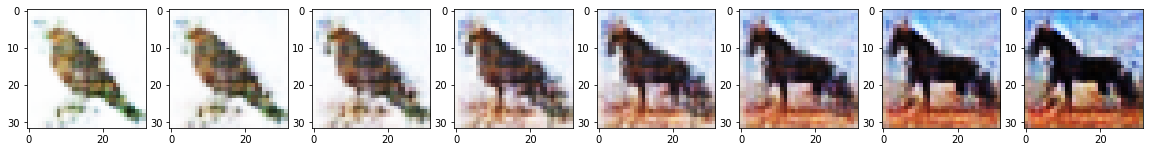

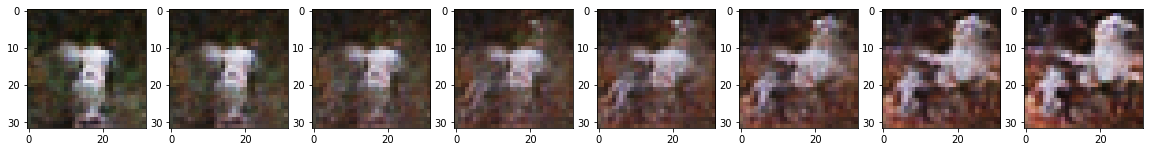

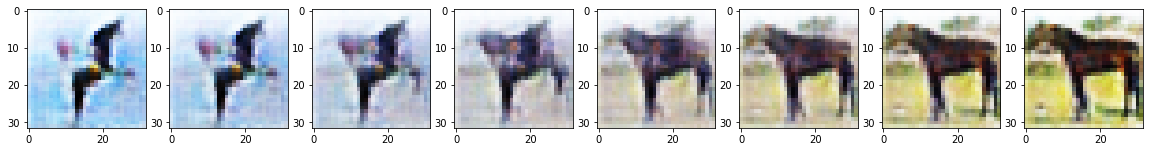

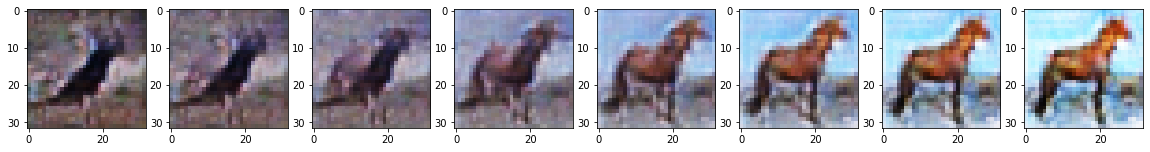

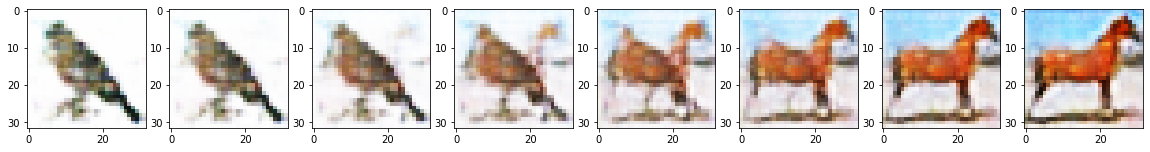

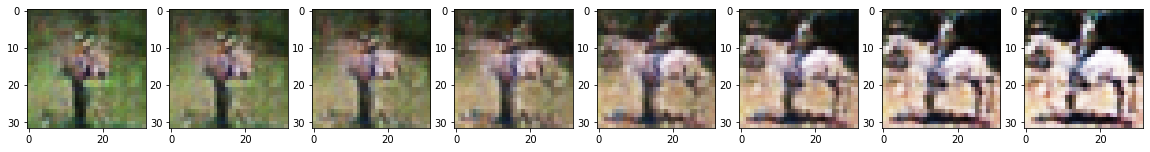

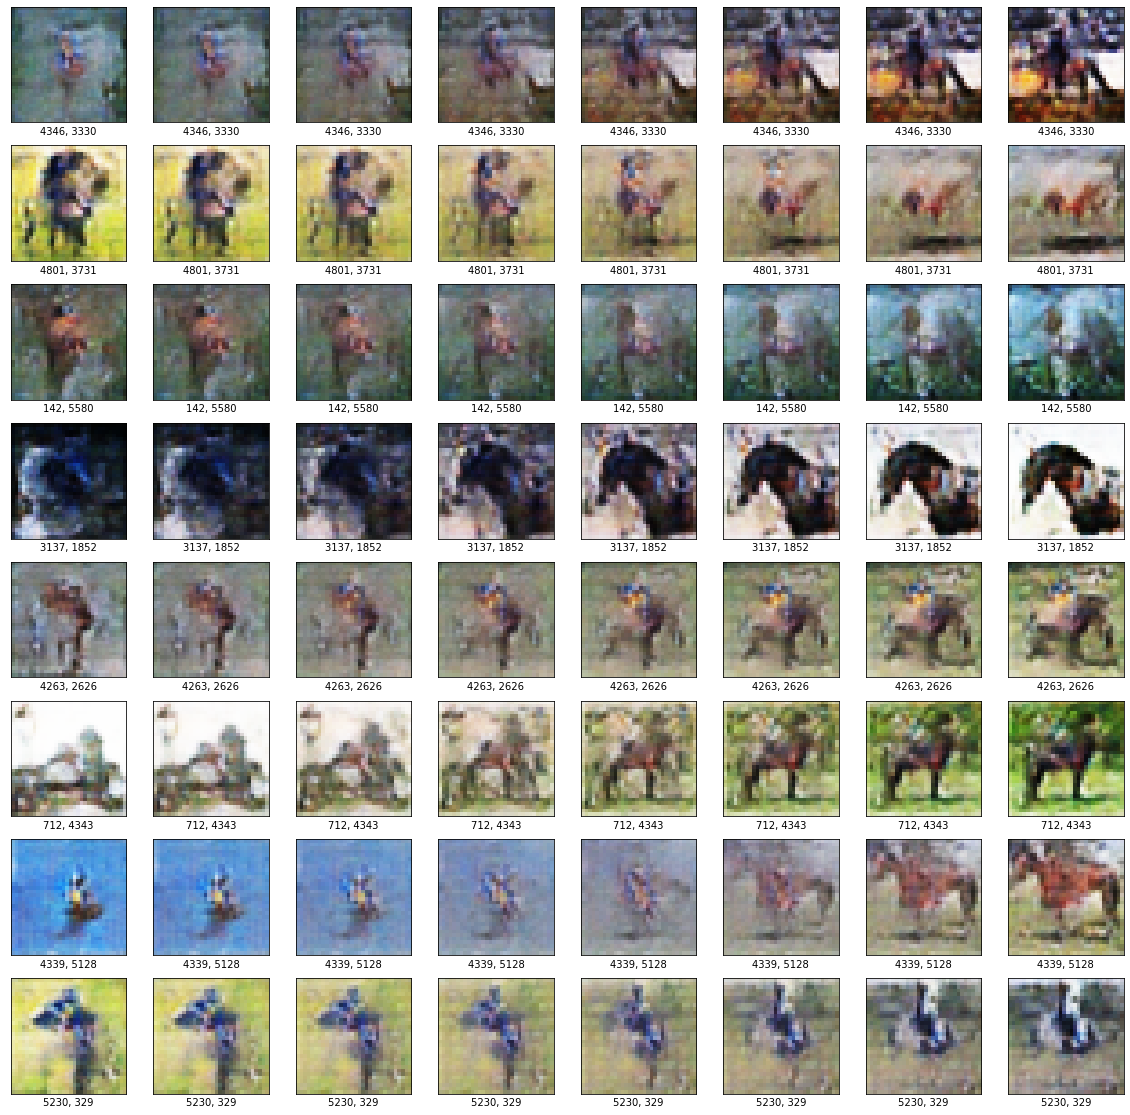

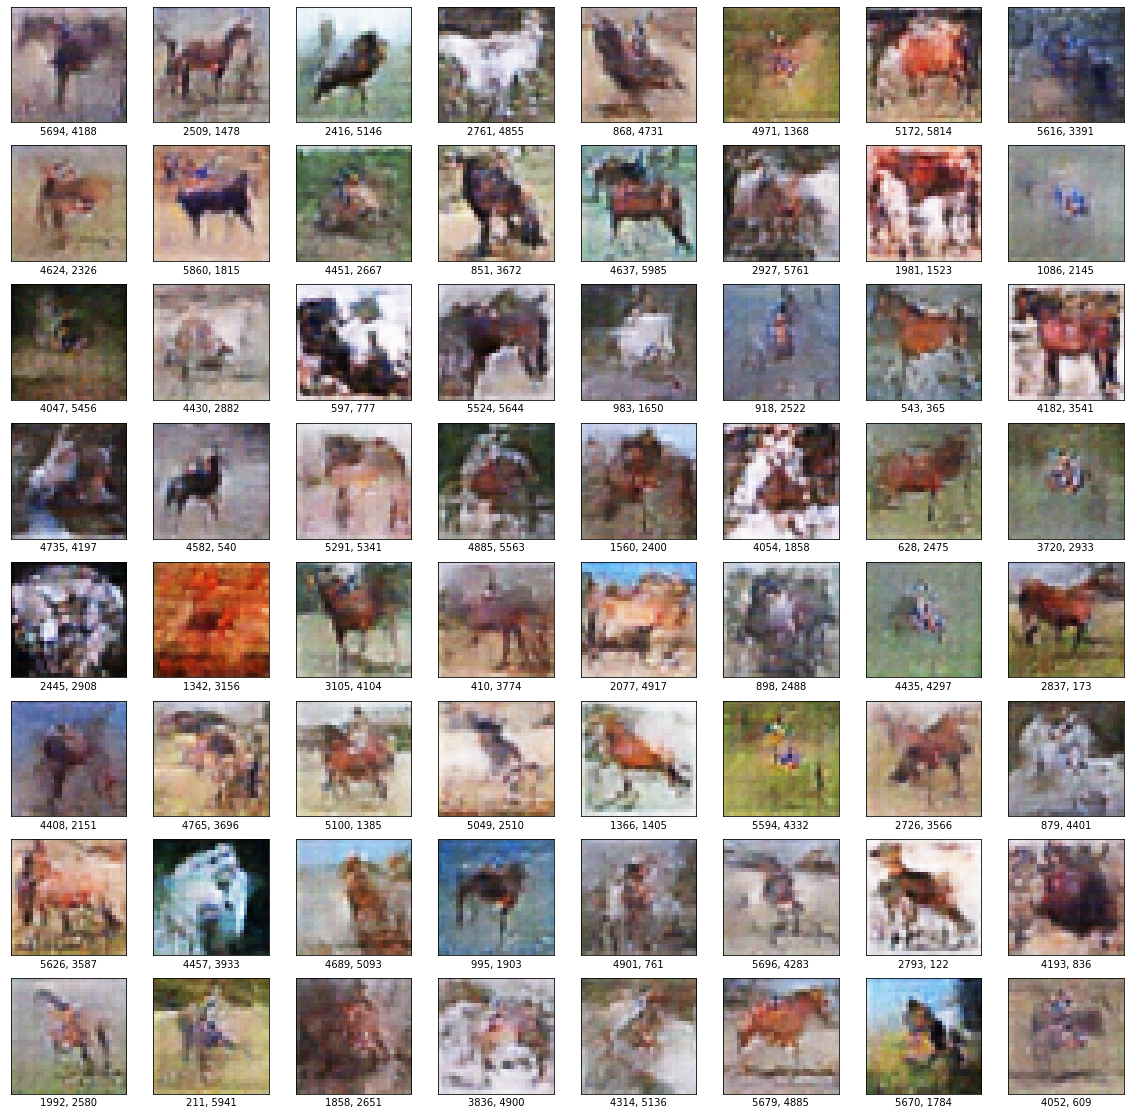

In [75]:
# reload training data, but shuffle is false this time
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=False, batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=64, drop_last=True)

# re-separate the horses and birds
horses = []
birds = []
for loader in [train_loader, test_loader]:
	  for i, data in enumerate(loader, 0):
		    inputs, labels = data[0], data[1]
		    for j in range(len(data[0])):
			      if labels[j] == 7:
				        horses += [inputs[j]]
			      if labels[j] == 2:
				        birds += [inputs[j]]

# set the networks to evaluation mode
D.eval()
E.eval()


# best combination of images found so far
plt.figure(figsize=(20,20))
z_1 = horses[4795].to(device)
z_2 = birds[2654].to(device)

z_1_code, _, _ = E(z_1.unsqueeze(0))
z_2_code, _, _ = E(z_2.unsqueeze(0))

for j in range(8):
    plt.subplot(1,8,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    pegasus = D((j / 7) * z_1_code + (1 - (j / 7)) * z_2_code).squeeze(0)
    pegasus = pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0)

    plt.imshow(pegasus, cmap=plt.cm.binary)


# generate 8 random interpolation sequences
plt.figure(figsize=(20,20))
for i in range(8):
    a, b = random.randrange(0, len(horses)), random.randrange(0, len(birds))
    horse, bird = np.transpose(horses[a], (1,2,0)), np.transpose(birds[b], (1,2,0))

    c = False
    while not c:
        # pythagorean theorem to get distance between two 3-channel pixels
        # max d is sqrt(3), ~1.73
        d = (torch.sum((horse[16][16] - bird[16][16])**2))**0.5
        # make sure the two pixels are close in value
        if d < 0.1:
            c = True
        else:
            b = random.randrange(0, len(birds))
            bird = np.transpose(birds[b], (1,2,0))

    z_1 = horses[a].to(device)
    z_2 = birds[b].to(device)

    z_1_code, _, _ = E(z_1.unsqueeze(0))
    z_2_code, _, _ = E(z_2.unsqueeze(0))

    for j in range(8):
        plt.subplot(8,8,(8*i)+j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        pegasus = D((j / 7) * z_1_code + (1 - (j / 7)) * z_2_code).squeeze(0)
        pegasus = pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0)

        plt.imshow(pegasus, cmap=plt.cm.binary)
        plt.xlabel("%d, %d" % (a, b))


# generate 64 random samples, where the interpolation ratio is between [0.4,0.6]
plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    a, b = random.randrange(0, len(horses)), random.randrange(0, len(birds))
    horse, bird = np.transpose(horses[a], (1,2,0)), np.transpose(birds[b], (1,2,0))

    c = False
    while not c:
        d = (torch.sum((horse[16][16] - bird[16][16])**2))**0.5
        if d < 0.1:
            c = True
        else:
            b = random.randrange(0, len(birds))
            bird = np.transpose(birds[b], (1,2,0))
    z_1 = horses[a].to(device)
    z_2 = birds[b].to(device)

    z_1_code, _, _ = E(z_1.unsqueeze(0))
    z_2_code, _, _ = E(z_2.unsqueeze(0))
    
    j = random.uniform(0.4, 0.6)
    pegasus = D(j * z_1_code + (1 - j) * z_2_code).squeeze(0)
    pegasus = pegasus.cpu().data.permute(0,2,1).contiguous().permute(2,1,0)

    plt.imshow(pegasus, cmap=plt.cm.binary)
    plt.xlabel("%d, %d" % (a, b))

In [0]:
path_ae = "./ae.pth"
path_c = "./c.pth"
torch.save(AE.state_dict(), path_ae)
torch.save(C.state_dict(), path_c)
files.download(path_ae)
files.download(path_c)